<a href="https://colab.research.google.com/github/zzhining/time_series_basic/blob/main/%EB%B0%95%EA%B3%B0%ED%9D%ACTV_etf_%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경셋팅

In [ ]:
# (라이브러리 설치 후 런타임 재시작 필요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
 !pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Matplotlib 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')      

# 준비

## 포트폴리오 셋팅하기
- [포트폴리오 엑셀](https://docs.google.com/spreadsheets/d/1t3miL8klvWwMqial9tXFSvUMEHvsKMjE/edit?rtpof=true)
- [Youtube](https://youtu.be/zg_CgpmpwhQ)

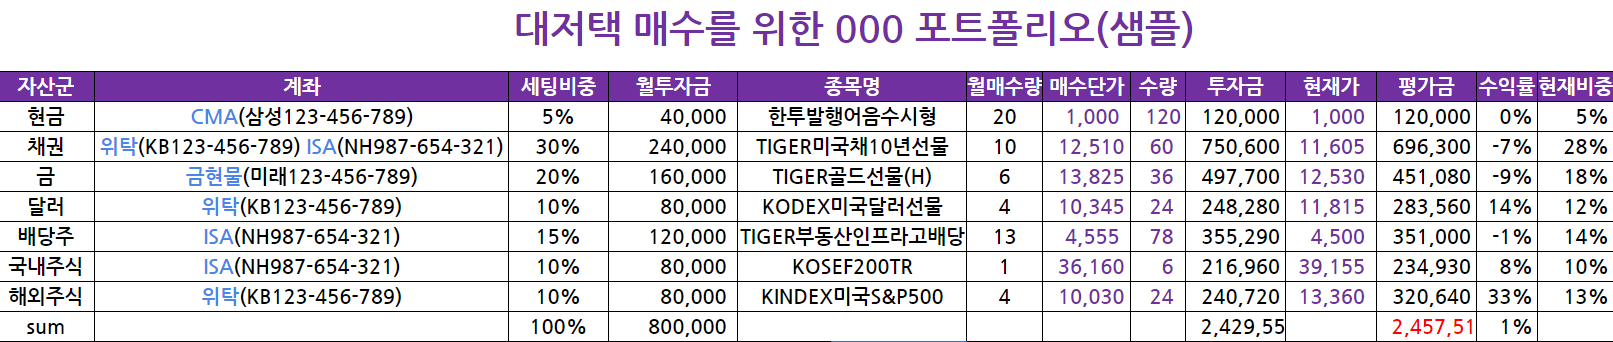

- 현금 비중을 0으로 하고, 해외 주식의 비중을 15%로 설정하였습니다.
- 자산군 별 종목은 위의 내용과 상이할 수 있습니다.

In [ ]:
def create_portfolio_base():
    category = ['채권', '금', '달러', '배당주', '국내주식', '해외주식']
    ratio = [30, 20, 10, 15, 10, 15]
    ticker = [#'438560', #SOL국고채3년
            '305080', #TIGER 미국채10년선물
            '411060', #ACE KRX금현물
            '261240', #KODEX 미국달러선물
            '161510', #ARIRANG 고배당주
            '069660', #KOSEF 200
            '360750' #TIGER 미국S&P500
            ]

    df = pd.DataFrame({'자산군': category,
                    '세팅비중': ratio,
                    '티커': ticker})
    return df

base_df = create_portfolio_base()
base_df

,자산군,세팅비중,티커
0,채권,30,305080
1,금,20,411060
2,달러,10,261240
3,배당주,15,161510
4,국내주식,10,069660
5,해외주식,15,360750


### 예상투자금 설정

월 100만원을 투자한다고 가정하고,세팅 비중에 따라 자산별 투자금액을 설정합니다.

In [ ]:
def set_monthly_pred_investment(df, total):
    invest_ratio = []
    for i in df['세팅비중']:
        invest_ratio.append(total*i/100)
    df['예상투자금'] = invest_ratio
    return df

In [ ]:
df = set_monthly_pred_investment(base_df, 1000000)
df

,자산군,세팅비중,티커,예상투자금
0,채권,30,305080,300000.0
1,금,20,411060,200000.0
2,달러,10,261240,100000.0
3,배당주,15,161510,150000.0
4,국내주식,10,069660,100000.0
5,해외주식,15,360750,150000.0


## 현재 금액 읽어오기

[pykrx 모듈](https://github.com/sharebook-kr/pykrx)을 사용하여 항목별 현재 가격을 읽어옵니다.


### 종목명 업데이트
티커는 인지하기 어떤 종목인지 인지하기 어려우므로, 종목명을 읽어옵니다.

In [ ]:
from pykrx import stock

def set_etf_name(df):
    name = []
    for i in df['티커']:
        name.append(stock.get_etf_ticker_name(i))
    df['종목명'] = name
    return df

In [ ]:
df = set_etf_name(df)
df

,자산군,세팅비중,티커,예상투자금,종목명
0,채권,30,305080,300000.0,TIGER 미국채10년선물
1,금,20,411060,200000.0,ACE KRX금현물
2,달러,10,261240,100000.0,KODEX 미국달러선물
3,배당주,15,161510,150000.0,ARIRANG 고배당주
4,국내주식,10,069660,100000.0,KOSEF 200
5,해외주식,15,360750,150000.0,TIGER 미국S&P500


날짜에 따라 해당 ETF가 운용시작전이었을 수도 있고, 장이 열리지 않는 날일 수 있습니다.
운용 시작 전인 경우에는 현재 금액을 0으로 설정하고, 장이 열리지 않는 날인 경우에는 그 다음 날짜를 설정하여 가격을 읽어옵니다.

In [ ]:
from datetime import datetime, timedelta
def set_current_price(df, date):
    flag = True
    ohlcv_df = None
    while flag:
        ohlcv_df = stock.get_etf_ohlcv_by_ticker(date)
        if len(ohlcv_df) == 0:
            if type(date) == str:
                date = datetime.strptime(date, '%Y-%m-%d')
            date_obj = date + timedelta(days=1)
            date = str(date_obj)[:10]
        else:
            flag = False

    price = []
    for i in df['티커']:
        if ohlcv_df.index.isin([i]).sum() > 0:
            price.append(ohlcv_df.loc[i, '종가'])
        else:
            print('{}에 {}가 존재하지 않습니다.'.format(date, i))
            price.append(0)
    df['현재가'] = price
    df['투자날짜'] = str(date)[:10]
    return df

In [ ]:
df = set_current_price(df, '2023-03-10')
df

,자산군,세팅비중,티커,예상투자금,종목명,현재가,투자날짜
0,채권,30,305080,300000.0,TIGER 미국채10년선물,11590,2023-03-10
1,금,20,411060,200000.0,ACE KRX금현물,11165,2023-03-10
2,달러,10,261240,100000.0,KODEX 미국달러선물,11915,2023-03-10
3,배당주,15,161510,150000.0,ARIRANG 고배당주,11870,2023-03-10
4,국내주식,10,069660,100000.0,KOSEF 200,31460,2023-03-10
5,해외주식,15,360750,150000.0,TIGER 미국S&P500,12915,2023-03-10


## 보유 수량 설정

`예상투자금`으로 각 종목을 얼마나 구매 가능한 지 보유수량을 결정합니다.
`수량`은 `예상투자금`을 `현재가`로 나누어 반올림하여 정하였습니다.
따라서 실제 투자금은 `예상투자금`보다 클 수 있습니다.

In [ ]:
def get_volume(df):
    df['수량'] = np.round(df['예상투자금']/df['현재가'])
    df['수량'].replace(np.inf, 0, inplace= True)
    df['수량'] = df['수량'].astype(int)
    return df

In [ ]:
df = get_volume(df)
df

,자산군,세팅비중,티커,예상투자금,종목명,현재가,투자날짜,수량
0,채권,30,305080,300000.0,TIGER 미국채10년선물,11590,2023-03-10,26
1,금,20,411060,200000.0,ACE KRX금현물,11165,2023-03-10,18
2,달러,10,261240,100000.0,KODEX 미국달러선물,11915,2023-03-10,8
3,배당주,15,161510,150000.0,ARIRANG 고배당주,11870,2023-03-10,13
4,국내주식,10,069660,100000.0,KOSEF 200,31460,2023-03-10,3
5,해외주식,15,360750,150000.0,TIGER 미국S&P500,12915,2023-03-10,12


## 실투자금 업데이트

 위에서 계산한 종목별 `수량`에 따라 `현재가`로 구매했을 시, 실제 발생한 투자금을 업데이트 합니다. 실제 투자금은 수수료가 추가로 부가되지만, 수수료에 대한 부분은 고려하지 않았습니다.

In [ ]:
def get_monthly_investment(df):
    df['실투자금'] = df['현재가']*df['수량']
    return df

In [ ]:
df = get_monthly_investment(df)
df

,자산군,세팅비중,티커,예상투자금,종목명,현재가,투자날짜,수량,실투자금
0,채권,30,305080,300000.0,TIGER 미국채10년선물,11590,2023-03-10,26,301340
1,금,20,411060,200000.0,ACE KRX금현물,11165,2023-03-10,18,200970
2,달러,10,261240,100000.0,KODEX 미국달러선물,11915,2023-03-10,8,95320
3,배당주,15,161510,150000.0,ARIRANG 고배당주,11870,2023-03-10,13,154310
4,국내주식,10,069660,100000.0,KOSEF 200,31460,2023-03-10,3,94380
5,해외주식,15,360750,150000.0,TIGER 미국S&P500,12915,2023-03-10,12,154980


In [ ]:
sum(df['실투자금'])

1001300

----

# 일자별 투자 리포트 생성하기 

위에서 설정한 로직을 수행하는 함수를 생성합니다.

In [ ]:
def get_portfolio_by_date(total, date):
    base_df = create_portfolio_base()
    df = set_monthly_pred_investment(base_df, total)
    df = set_etf_name(df)
    df = set_current_price(df, date)
    df = get_volume(df)
    df = get_monthly_investment(df)
    return df

In [ ]:
march_df = get_portfolio_by_date(800000, '20210304')
march_df

20210304에 411060가 존재하지 않습니다.


,자산군,세팅비중,티커,예상투자금,종목명,현재가,투자날짜,수량,실투자금
0,채권,30,305080,240000.0,TIGER 미국채10년선물,11510,20210304,21,241710
1,금,20,411060,160000.0,ACE KRX금현물,0,20210304,0,0
2,달러,10,261240,80000.0,KODEX 미국달러선물,9965,20210304,8,79720
3,배당주,15,161510,120000.0,ARIRANG 고배당주,11205,20210304,11,123255
4,국내주식,10,069660,80000.0,KOSEF 200,42210,20210304,2,84420
5,해외주식,15,360750,120000.0,TIGER 미국S&P500,10800,20210304,11,118800


## 기간별 수익률 계산
- 2022년 1월 1일부터 2023년 3월 10일까지 매달 초에 한 번씩 투자를 진행했을 경우 수익률을 계산합니다. 월투자금은 22년 1월, 22년 7월, 23년 1월에는 100만원으로 늘려서 설정하였습니다. 

In [ ]:
history_df = pd.DataFrame(columns= ['날짜'], 
                          data = pd.date_range('2022-01-01', '2023-03-10', freq='BMS'))
history_df['월투자금']=800000
history_df.iloc[[0,6,12], 1]=1000000

In [ ]:
history_df

,날짜,월투자금
0,2022-01-03,1000000
1,2022-02-01,800000
2,2022-03-01,800000
3,2022-04-01,800000
4,2022-05-02,800000
5,2022-06-01,800000
6,2022-07-01,1000000
7,2022-08-01,800000
8,2022-09-01,800000
9,2022-10-03,800000


In [ ]:
def get_balance(df):
    total_df = None
    value_list= []
    for index, d in df.iterrows():
        month_df = get_portfolio_by_date(d['월투자금'], d['날짜'])
        # display(month_df)
        # print(month_df['실투자금'].sum())
        if total_df is None:
            total_df = month_df
        else:
            total_df = pd.concat([total_df, month_df])      
    
        volumes = total_df.groupby(['종목명']).sum()['수량']
        monthly_value = 0
        for index, value in volumes.iteritems():
            price = month_df.query("종목명 == '{}'".format(index))['현재가'].values
            monthly_value += price * value
        value_list.extend(monthly_value)

    df['월투자금'] = total_df.groupby(['투자날짜']).sum()['실투자금'].values
    df['평가금액'] = value_list
    return total_df, df

In [ ]:
total_df, history_df = get_balance(history_df)
history_df['누적투자금'] = history_df['월투자금'].cumsum()
history_df['수익률'] = history_df['누적투자금']/history_df['평가금액']
history_df

,날짜,월투자금,평가금액,누적투자금,수익률
0,2022-01-03,1017345,1017345,1017345,1.000000
1,2022-02-01,802320,1802740,1819665,1.009388
2,2022-03-01,805780,2617385,2625445,1.003079
3,2022-04-01,802125,3447105,3427570,0.994333
4,2022-05-02,793885,4198740,4221455,1.005410
5,2022-06-01,794290,4936595,5015745,1.016033
6,2022-07-01,983400,5823525,5999145,1.030157
7,2022-08-01,783095,6739065,6782240,1.006407
8,2022-09-01,827765,7573410,7610005,1.004832
9,2022-10-03,794800,8425405,8404805,0.997555


In [ ]:
total_df['투자날짜'] = pd.to_datetime(total_df['투자날짜'])
total_df.set_index('투자날짜', inplace = True)
total_df

,자산군,세팅비중,티커,예상투자금,종목명,현재가,수량,실투자금
투자날짜,,,,,,,,
2022-01-03,채권,30,305080,300000.0,TIGER 미국채10년선물,12145,25,303625
2022-01-03,금,20,411060,200000.0,ACE KRX금현물,10255,20,205100
2022-01-03,달러,10,261240,100000.0,KODEX 미국달러선물,10545,9,94905
2022-01-03,배당주,15,161510,150000.0,ARIRANG 고배당주,12510,12,150120
2022-01-03,국내주식,10,069660,100000.0,KOSEF 200,39965,3,119895
...,...,...,...,...,...,...,...,...
2023-03-02,금,20,411060,160000.0,ACE KRX금현물,11030,15,165450
2023-03-02,달러,10,261240,80000.0,KODEX 미국달러선물,11820,7,82740
2023-03-02,배당주,15,161510,120000.0,ARIRANG 고배당주,12200,10,122000


## 날짜별 각 종목 투자 현황

In [ ]:
pd.pivot_table(total_df, values = '수량', 
               index = '투자날짜', columns = '종목명',
               aggfunc = np.sum)

종목명,ACE KRX금현물,ARIRANG 고배당주,KODEX 미국달러선물,KOSEF 200,TIGER 미국S&P500,TIGER 미국채10년선물
투자날짜,,,,,,
2022-01-03,20,12,9,3,10,25
2022-02-03,16,10,7,2,9,20
2022-03-02,15,10,8,2,9,20
2022-04-01,15,9,7,2,9,21
2022-05-02,14,10,7,2,9,21
2022-06-02,15,10,7,2,9,21
2022-07-01,18,13,9,3,12,25
2022-08-01,15,11,7,2,9,19
2022-09-01,15,11,7,3,9,20


## 종목별 가격 시각화



In [ ]:
etf_pivot = pd.pivot_table(total_df, values = '현재가', 
               index = '투자날짜', columns = '종목명',
               aggfunc = np.sum)
etf_pivot

종목명,ACE KRX금현물,ARIRANG 고배당주,KODEX 미국달러선물,KOSEF 200,TIGER 미국S&P500,TIGER 미국채10년선물
투자날짜,,,,,,
2022-01-03,10255,12510,10545,39965,14370,12145
2022-02-03,10265,12500,10670,36630,13770,12060
2022-03-02,10810,12595,10655,36520,13100,12075
2022-04-01,10980,13310,10745,36830,13930,11590
2022-05-02,11140,12490,11180,35320,13205,11680
2022-06-02,10800,12530,11075,35025,12915,11580
2022-07-01,10865,11220,11480,30510,12260,12000
2022-08-01,10640,11155,11550,32410,13470,12310
2022-09-01,10675,11185,12010,31535,13370,12280


<AxesSubplot:xlabel='투자날짜'>

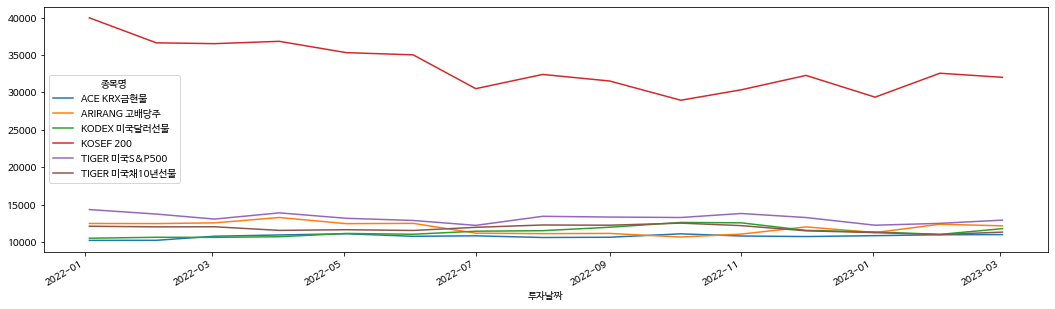

In [ ]:
etf_pivot.plot(figsize=(18,5))

<AxesSubplot:xlabel='종목명'>

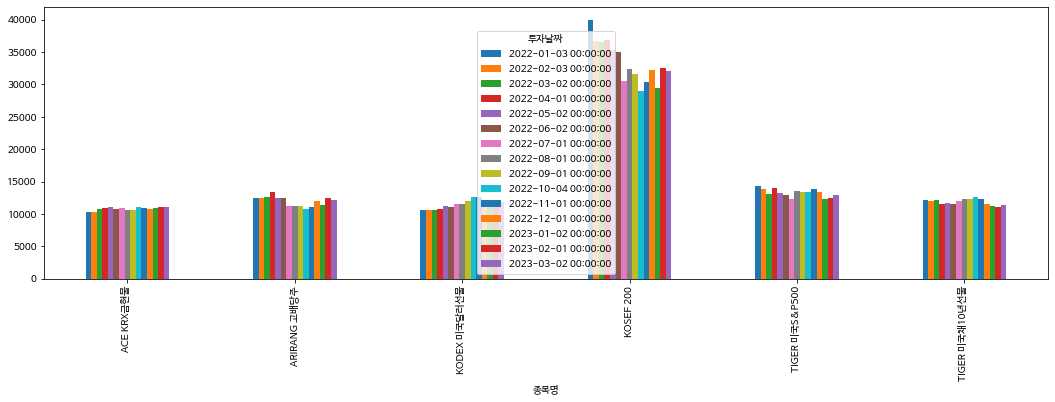

In [ ]:
etf_pivot.T.plot(kind = 'bar', figsize=(18,5))

## 기간별 수익률 계산2

기간을 늘려 2020년 1월 1일부터 2023년 3월 10일까지 매달 초 80만원씩 투자하였을 때의 수익률을 확인합니다. 

In [ ]:
history_df2 = pd.DataFrame(columns= ['날짜'], 
                          data = pd.date_range('2020-01-01', '2023-03-10', freq='BMS'))
history_df2['월투자금']=800000

In [ ]:
total_df2, history_df2 = get_balance(history_df2)
history_df2['누적투자금'] = history_df2['월투자금'].cumsum()
history_df2['수익률'] = history_df2['누적투자금']/history_df2['평가금액']
history_df2

2020-01-02에 411060가 존재하지 않습니다.
2020-01-02에 360750가 존재하지 않습니다.
2020-02-03 00:00:00에 411060가 존재하지 않습니다.
2020-02-03 00:00:00에 360750가 존재하지 않습니다.
2020-03-02 00:00:00에 411060가 존재하지 않습니다.
2020-03-02 00:00:00에 360750가 존재하지 않습니다.
2020-04-01 00:00:00에 411060가 존재하지 않습니다.
2020-04-01 00:00:00에 360750가 존재하지 않습니다.
2020-05-04에 411060가 존재하지 않습니다.
2020-05-04에 360750가 존재하지 않습니다.
2020-06-01 00:00:00에 411060가 존재하지 않습니다.
2020-06-01 00:00:00에 360750가 존재하지 않습니다.
2020-07-01 00:00:00에 411060가 존재하지 않습니다.
2020-07-01 00:00:00에 360750가 존재하지 않습니다.
2020-08-03 00:00:00에 411060가 존재하지 않습니다.
2020-08-03 00:00:00에 360750가 존재하지 않습니다.
2020-09-01 00:00:00에 411060가 존재하지 않습니다.
2020-10-05에 411060가 존재하지 않습니다.
2020-11-02 00:00:00에 411060가 존재하지 않습니다.
2020-12-01 00:00:00에 411060가 존재하지 않습니다.
2021-01-04에 411060가 존재하지 않습니다.
2021-02-01 00:00:00에 411060가 존재하지 않습니다.
2021-03-02에 411060가 존재하지 않습니다.
2021-04-01 00:00:00에 411060가 존재하지 않습니다.
2021-05-03 00:00:00에 411060가 존재하지 않습니다.
2021-06-01 00:00:00에 411060가 존재하지 않습니다.
2021-07-01 00:00:00에 41

,날짜,월투자금,평가금액,누적투자금,수익률
0,2020-01-01,525770,525770,525770,1.000000
1,2020-02-03,529660,1060415,1055430,0.995299
2,2020-03-02,531685,1577740,1587115,1.005942
3,2020-04-01,499250,2027465,2086365,1.029051
4,2020-05-01,506070,2586855,2592435,1.002157
5,2020-06-01,510485,3159950,3102920,0.981952
6,2020-07-01,531840,3627755,3634760,1.001931
7,2020-08-03,538830,4214105,4173590,0.990386
8,2020-09-01,648355,4888235,4821945,0.986439
9,2020-10-01,650380,5518830,5472325,0.991573


In [ ]:
px.line(history_df2, x = '날짜', y = '수익률', template="plotly_dark")

In [ ]:
total_df2['투자날짜'] = pd.to_datetime(total_df2['투자날짜'])

,투자날짜,자산군,세팅비중,티커,예상투자금,종목명,현재가,수량,실투자금
0,2020-01-02,채권,30,305080,240000.0,TIGER 미국채10년선물,11250,21,236250
1,2020-01-02,금,20,411060,160000.0,ACE KRX금현물,0,0,0
2,2020-01-02,달러,10,261240,80000.0,KODEX 미국달러선물,10155,8,81240
3,2020-01-02,배당주,15,161510,120000.0,ARIRANG 고배당주,11885,10,118850
4,2020-01-02,국내주식,10,069660,80000.0,KOSEF 200,29810,3,89430
...,...,...,...,...,...,...,...,...,...
229,2023-03-02,금,20,411060,160000.0,ACE KRX금현물,11030,15,165450
230,2023-03-02,달러,10,261240,80000.0,KODEX 미국달러선물,11820,7,82740
231,2023-03-02,배당주,15,161510,120000.0,ARIRANG 고배당주,12200,10,122000
232,2023-03-02,국내주식,10,069660,80000.0,KOSEF 200,32025,2,64050


In [ ]:
px.line(total_df2, x = '투자날짜', y = '현재가', color='자산군', template="plotly_dark")